<a href="https://colab.research.google.com/github/ekity1002/PyOptBook-memo/blob/main/Python%E3%81%A7%E3%81%AF%E3%81%98%E3%82%81%E3%82%8B%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96_7%E7%AB%A0%E3%83%A1%E3%83%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/ohmsha/PyOptBook.git
! cd PyOptBook; pip install -r requirements.txt

Cloning into 'PyOptBook'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 187 (delta 71), reused 61 (delta 41), pack-reused 76
Receiving objects: 100% (187/187), 2.25 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 8.2 MB/s 
     |████████████████████████████████| 121 kB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 35.7 MB/s 
     |████████████████████████████████| 83 kB 935 kB/s 


# 商品推薦のための興味のスコアリング
 データ確認

In [ ]:
import pandas as pd
log_df = pd.read_csv('/content/PyOptBook/7.recommendation/access_log.csv')
log_df['date'] = pd.to_datetime(log_df['date'])
log_df

,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04
...,...,...,...
325903,424168,454500,2015-07-01
325904,424168,189002,2015-07-01
325905,424168,1020948,2015-07-01
325906,424168,96441,2015-07-04


In [ ]:
log_df['user_id'].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: user_id, dtype: float64

In [ ]:
log_df['item_id'].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: item_id, dtype: float64

In [ ]:
log_df['date'].value_counts()

2015-07-03    45441
2015-07-02    45394
2015-07-01    44163
2015-07-04    43804
2015-07-08    39933
2015-07-05    39932
2015-07-07    33930
2015-07-06    33311
Name: date, dtype: int64

データの全体感を確認
* １週間分のデータ
* ユーザーの平均閲覧数 5回
* 商品の平均閲覧数 2回

# 商品に対する性質を仮定
* 最近の閲覧されたものほど、ユーザーが興味がある
* たくさん閲覧されたものほど、ユーザーが興味がある

In [ ]:
# 日付操作をするライブラリdatetimeを取り込む
import datetime

start_date = datetime.datetime(2015,7,1)
end_date = datetime.datetime(2015,7,7)
target_date = datetime.datetime(2015,7,8)
print(start_date, end_date, target_date) # 追記

2015-07-01 00:00:00 2015-07-07 00:00:00 2015-07-08 00:00:00


In [ ]:
# 7月1日〜7月7日までのデータを抽出する（基準日7月8日は入っていない）
x_df = log_df[(start_date <= log_df['date']) & (log_df['date'] <= end_date)]
print(len(x_df))
x_df.head(3)

285975


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [ ]:
# 基準日7月8日のデータを抽出する
y_df = log_df[log_df['date'] == target_date]
print(len(y_df))
y_df.head()

39933


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [ ]:
# ユーザーIDと閲覧した商品IDに対して、最新度のリストを対応させる辞書を作成する（ただし、辞書の入れ子として作成）
U2I2Rcens = {}
for row in x_df.itertuples():
    # 最新度(経過日数)の算出：基準日 - 最新の閲覧日
    rcen = (target_date - row.date).days
    
    # 辞書に最新度を登録
    U2I2Rcens.setdefault(row.user_id, {})
    U2I2Rcens[row.user_id].setdefault(row.item_id, [])
    U2I2Rcens[row.user_id][row.item_id].append(rcen)

In [ ]:
# ユーザーID=2497について、閲覧した商品に対する最新度のリストを確認する
U2I2Rcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

In [ ]:
# ユーザーIDと商品IDに対応する最新度(rcen)と頻度(freq)のデータを作成する
Rows1 = []
for user_id, I2Rcens in U2I2Rcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rows1.append((user_id, item_id, rcen, freq))

In [ ]:
UI2RF_df = pd.DataFrame(Rows1, columns=['user_id', 'item_id', 'rcen', 'freq'])
print(len(UI2RF_df))
UI2RF_df.head()

204661


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [ ]:
y_df

,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08
...,...,...,...
325715,423958,963019,2015-07-08
325716,423958,299985,2015-07-08
325717,423958,963019,2015-07-08
325718,423958,299985,2015-07-08


In [ ]:
# 閲覧フラグ(pv_flag)の作成
y_df = y_df.drop_duplicates()
print(len(y_df))
y_df['pv_flag'] = 1
y_df.head()

29651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1


In [ ]:
# 閲覧フラグ(pv_flag)の追加
# 未来にユーザーがそのアイテムを閲覧したかどうか
UI2RFP_df = pd.merge(UI2RF_df, y_df[['user_id', 'item_id', 'pv_flag']], how='left', on=['user_id', 'item_id'])
UI2RFP_df['pv_flag'].fillna(0, inplace=True)
print(len(UI2RFP_df))
UI2RFP_df.head()

204661


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [ ]:
# 最新度(rcen)と頻度(freq)の取りうる範囲を確認
print(sorted(UI2RFP_df['rcen'].unique()))
print(sorted(UI2RFP_df['freq'].unique()))

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 41, 43, 58, 63, 118]


In [ ]:
# 頻度(freq)が7以下になるようにデータを抽出(本書の都合でrcenと規模感を合わせるため)
# 多すぎる閲覧数のデータを削る
tar_df = UI2RFP_df[UI2RFP_df['freq'] <= 7]
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [ ]:
# 閲覧フラグ(pv_flag)の規模感の確認
tar_df['pv_flag'].sum()

2038.0

In [ ]:
# 最新度(recency)に関する閲覧数の集計
rcen_df = pd.crosstab(index=tar_df['rcen'], columns=tar_df['pv_flag'])
rcen_df = rcen_df.rename(columns = {0:'neg', 1:'pos'})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


＊直近に閲覧されたデータほど、購入される数は増えている

pv_flag,neg,pos,N,prob
rcen,,,,
1,24595,571,25166,0.022689
2,24032,274,24306,0.011273
3,28212,326,28538,0.011423
4,30641,275,30916,0.008895
5,31510,225,31735,0.007090
6,31721,199,31920,0.006234
7,30707,168,30875,0.005441


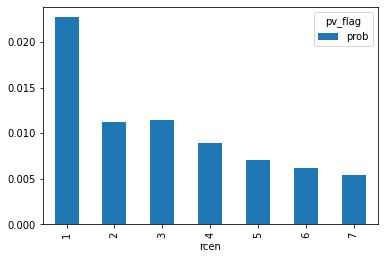

In [ ]:
# 最新度(recency)に関する再閲覧確率の算出と確認
rcen_df['N'] = rcen_df['neg'] + rcen_df['pos']
rcen_df['prob'] = rcen_df['pos'] / rcen_df['N']
rcen_df[['prob']].plot.bar()
rcen_df

In [ ]:
# 頻度(frequency)に関する閲覧数の集計
freq_df = pd.crosstab(index=tar_df['freq'], columns=tar_df['pv_flag'])
freq_df = freq_df.rename(columns = {0:'neg', 1:'pos'})
freq_df

pv_flag,neg,pos
freq,,
1,161753,964
2,24938,476
3,7733,258
4,3527,149
5,1807,88
6,1038,63
7,622,40


pv_flag,neg,pos,N,prob
freq,,,,
1,161753,964,162717,0.005924
2,24938,476,25414,0.018730
3,7733,258,7991,0.032286
4,3527,149,3676,0.040533
5,1807,88,1895,0.046438
6,1038,63,1101,0.057221
7,622,40,662,0.060423


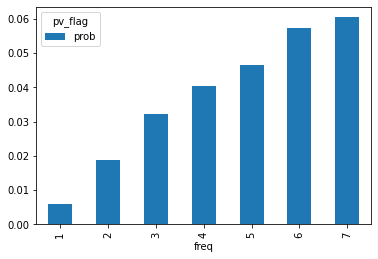

In [ ]:
# 頻度(frequency)に関する再閲覧確率の算出と確認
freq_df['N'] = freq_df['neg'] + freq_df['pos']
freq_df['prob'] = freq_df['pos'] / freq_df['N']
freq_df[['prob']].plot.bar()
freq_df

* 訪問数が多い商品ほど、購入率が上がっている

# モデリング

In [ ]:
# tar_dfの(再)確認
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [ ]:
# 最新度(rcen)と頻度(freq)に対する総件数と再閲覧件数の算出
RF2N = {}
RF2PV = {}
for row in tar_df.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen, row.freq] += 1

In [ ]:
# 最新度(rcen)と頻度(freq)に対する再閲覧確率の算出
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

In [ ]:
RF2N

{(4, 1): 24385,
 (4, 3): 1305,
 (4, 2): 4035,
 (3, 1): 22596,
 (7, 2): 3522,
 (7, 1): 25611,
 (5, 2): 3999,
 (5, 1): 25363,
 (4, 5): 300,
 (2, 4): 459,
 (5, 5): 274,
 (6, 1): 26034,
 (6, 4): 511,
 (6, 2): 3757,
 (1, 1): 19602,
 (1, 2): 3323,
 (3, 2): 3616,
 (6, 3): 1183,
 (2, 1): 19126,
 (7, 7): 43,
 (7, 3): 996,
 (2, 2): 3162,
 (4, 6): 185,
 (1, 3): 1120,
 (4, 4): 597,
 (1, 4): 539,
 (3, 3): 1161,
 (5, 3): 1225,
 (2, 3): 1001,
 (6, 6): 121,
 (5, 4): 603,
 (1, 7): 120,
 (5, 6): 173,
 (3, 4): 582,
 (3, 5): 279,
 (7, 5): 220,
 (6, 5): 235,
 (1, 5): 285,
 (7, 4): 385,
 (1, 6): 177,
 (5, 7): 98,
 (6, 7): 79,
 (2, 5): 302,
 (3, 6): 185,
 (2, 6): 162,
 (2, 7): 94,
 (4, 7): 109,
 (3, 7): 119,
 (7, 6): 98}

In [ ]:
# 最新度(rcen)と頻度(freq)に対して総件数、再閲覧件数、再閲覧確率を対応付けるデータの作成
Rows3 = []
for rf, N in sorted(RF2N.items()):
    pv = RF2PV[rf]
    prob = RF2Prob[rf]
    row = (rf[0], rf[1], N, pv, prob)
    Rows3.append(row)
rf_df = pd.DataFrame(Rows3, columns = ['rcen', 'freq', 'N', 'pv', 'prob'])
print(len(rf_df))
rf_df.head()

49


,rcen,freq,N,pv,prob
0,1,1,19602,245,0.012499
1,1,2,3323,132,0.039723
2,1,3,1120,81,0.072321
3,1,4,539,36,0.066790
4,1,5,285,36,0.126316


In [ ]:
# 横持ち（テーブル形式）で確認
rf_df.pivot_table(index='rcen', columns='freq', values='prob')

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.072321,0.066790,0.126316,0.112994,0.175000
2,0.005856,0.021189,0.026973,0.056645,0.066225,0.098765,0.063830
3,0.006107,0.023230,0.039621,0.053265,0.039427,0.054054,0.050420
4,0.005454,0.015366,0.024521,0.046901,0.036667,0.037838,0.018349
5,0.004376,0.015504,0.023673,0.014925,0.021898,0.028902,0.030612
6,0.004456,0.009848,0.024514,0.019569,0.008511,0.024793,0.025316
7,0.004256,0.009086,0.014056,0.023377,0.009091,0.020408,0.000000


In [ ]:
# データの可視化に必要なライブラリ群を取り込む
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

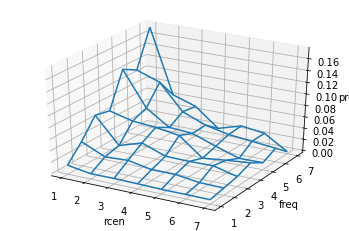

In [ ]:
# 最新度(rcen)と頻度(freq)に対して再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df['freq'].unique().tolist()
Rcen = rf_df['rcen'].unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['prob'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='prob'
                    )
ax.plot_wireframe(X, Y, Z)


# 数理最適化モデル
再閲覧確率を推定する問題と考える。要件
* 要件１rcenとfreqに対して、再閲覧率 pred_probを推定する.
* Recency: ユーザーは最近閲覧した商品に興味がある
  * 要件２；pred_prob は rcenについて単調減少する.（小さいほど最近閲覧された商品）
* Frequency: ユーザーは何度も閲覧した商品に興味がある
  * 要件３：prec_prob は freqについて単調増加する
* 推定した確率と、実測値の乖離を最小化する
  * 要件４：pred_prob と prob の二乗誤差を、総件数の重み付きで最小化する

## 凸二次計画問題としてレコメンドの定式化
凸二次計画問題：目的関数が凸な二次関数であり、制約式が線形の不等式で書ける最適化問題のことを指す。



・制約式 \ $\displaystyle Gx\leqslant \ h$

・目的関数 （最小化） : $\displaystyle ( 1/2) x^{T} Px+q^{T} x$



制約式の定義に使用するパラメータ

$\displaystyle G$ : 変数の係数行列

$\displaystyle h$ \ : 定数項のベクトル

目的関数の定義に使用するパラメータ

$\displaystyle P$ : 変数2次の項の係数行列

$\displaystyle q$ : 変数の1次の項の係数ベクトル\

# 上記記号の G,h,P,q をそのまま作成していく

In [ ]:
import cvxopt

In [ ]:
# 最新度(rcen)のリストと頻度(freq)のリストの作成
R = sorted(tar_df['rcen'].unique().tolist())
F = sorted(tar_df['freq'].unique().tolist())
print(R)
print(F)

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]


In [ ]:
# 最新度(rcen)と頻度(freq)のペアに対して変数の索引を作成する（何番目の変数かを決める）
Idx = []
RF2Idx = {}
idx = 0
for r in R:
    for f in F:
        Idx.append(idx)
        RF2Idx[r, f] = idx 
        idx += 1
print(Idx)
print(RF2Idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
{(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4, (1, 6): 5, (1, 7): 6, (2, 1): 7, (2, 2): 8, (2, 3): 9, (2, 4): 10, (2, 5): 11, (2, 6): 12, (2, 7): 13, (3, 1): 14, (3, 2): 15, (3, 3): 16, (3, 4): 17, (3, 5): 18, (3, 6): 19, (3, 7): 20, (4, 1): 21, (4, 2): 22, (4, 3): 23, (4, 4): 24, (4, 5): 25, (4, 6): 26, (4, 7): 27, (5, 1): 28, (5, 2): 29, (5, 3): 30, (5, 4): 31, (5, 5): 32, (5, 6): 33, (5, 7): 34, (6, 1): 35, (6, 2): 36, (6, 3): 37, (6, 4): 38, (6, 5): 39, (6, 6): 40, (6, 7): 41, (7, 1): 42, (7, 2): 43, (7, 3): 44, (7, 4): 45, (7, 5): 46, (7, 6): 47, (7, 7): 48}


In [ ]:
# 制約の定義に用いる行列Gとベクトルhを作成するための準備
G_list = []
h_list = []
var_vec = [0.0] * len(Idx)

In [ ]:
var_vec[:] == var_vec

True

In [ ]:
# - pred_prob[r,f] <= 0 のモデリング
# つまり pred_prob[r,f] >= 0 
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = -1 # pred_prob[r,f]の係数は-1（マイナスをかけて条件を考えているので）
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0
        
# pred_prob[r,f] <= 1 のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = 1 # pred_prob[r,f]の係数は1
        G_list.append(G_row)
        h_list.append(1) # 右辺は定数項1     

(2)pred_probはrcenについて単調減少する

In [ ]:
# - pred_prob[r,f] + pred_prob[r+1,f] <= 0 のモデリング
for r in R[:-1]:
    for f in F:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r+1,f]
        G_row = var_vec[:]
        G_row[idx1] = -1 # pred_prob[r,f]の係数は-1
        G_row[idx2] = 1  # pred_prob[r+1,f]の係数は1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0

(3)pred_probはfreqについて単調増加する

In [ ]:
# pred_prob[r,f] - pred_prob[r,f+1] <= 0 のモデリング
for r in R:
    for f in F[:-1]:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r,f+1]
        G_row = var_vec[:]
        G_row[idx1] = 1  # pred_prob[r,f]の係数は1
        G_row[idx2] = -1 # pred_prob[r,f+1]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0

(4)pred_probとprobの二乗誤差を総件数の重み付きで最小化する

In [ ]:
# 目的関数の定義に用いる行列Pとベクトルqを作成するための準備
P_list = []
q_list = []

* 定数：総件数 
  * $\displaystyle N_{r}{}_{,}{}_{f}$ ($\displaystyle r\in R,\ f\in F$)



* 定数：再閲覧率の実績値
  * $\displaystyle prob_{r}{}_{,}{}_{f} \ ( r\in R,\ f\in F)$

* 再閲覧確率の推定値と、実績値との乖離を総件数の重み付きで最小化する
  * $\displaystyle minimize\ \sum _{r\in R,f\in F} N_{r}{}_{,}{}_{f} ・( pred$\_$\displaystyle prob_{r}{}_{,}{}_{f} -prob_{r}{}_{,}{}_{f})^{2}$

* 上記式を展開したときの第3項
  * $\displaystyle N_{r}{}_{,} ・prob_{r}{}_{,}{}_{f}^{2}$
は、定数項なので、最適化の制約に含めなくてよい


* 2次計画問題の定式化の式
  * $\displaystyle minimize\ \frac{1}{2} x^{T} Px+q^{T} x$ 
$\displaystyle　 s.t　\ Gx\ \leqq \ h$


より、係数Pに当たる数値（このケースではN）にあらかじめ 1/2 をかけておく必要がある}

In [ ]:
# N[r,f] * pred_prob[r,f]^2 - 2 * N[r,f] * pred_prob[r,f] のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        N = RF2N[r,f]
        prob = RF2Prob[r,f]
        P_row = var_vec[:]
        P_row[idx] = 2 * N # (1/2)を打ち消すために2を掛ける
        P_list.append(P_row)
        ｑ_list.append( - 2 * N * prob)

In [ ]:
#G_list

In [ ]:
# 行列の作成
G = cvxopt.matrix(np.array(G_list), tc='d')
h = cvxopt.matrix(np.array(h_list), tc='d')
P = cvxopt.matrix(np.array(P_list), tc='d')
q = cvxopt.matrix(np.array(q_list), tc='d')

In [ ]:
# 求解
sol = cvxopt.solvers.qp(P, q, G, h)
status = sol['status']
status

     pcost       dcost       gap    pres   dres
 0: -5.2389e+01 -1.0625e+02  4e+02  2e+00  1e-02
 1: -5.2153e+01 -7.1273e+01  3e+01  5e-02  3e-04
 2: -5.2167e+01 -5.9818e+01  1e+01  2e-02  1e-04
 3: -5.1831e+01 -5.4852e+01  3e+00  2e-03  1e-05
 4: -5.1954e+01 -5.2335e+01  4e-01  2e-04  1e-06
 5: -5.1980e+01 -5.2002e+01  2e-02  4e-06  3e-08
 6: -5.1983e+01 -5.1983e+01  8e-04  1e-07  7e-10
 7: -5.1983e+01 -5.1983e+01  3e-05  2e-09  1e-11
Optimal solution found.


'optimal'

In [ ]:
# 最新度(rcen)と頻度(freq)に対応する推定した再閲覧確率の辞書を作成
RF2PredProb = {}
X = sol['x']
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        pred_prob = X[idx]
        RF2PredProb[r,f] = pred_prob
rf_df['pred_prob'] = rf_df.apply(lambda x:RF2PredProb[x['rcen'], x['freq']], axis=1)
rf_df.head()    

,rcen,freq,N,pv,prob,pred_prob
0,1,1,19602,245,0.012499,0.012499
1,1,2,3323,132,0.039723,0.039723
2,1,3,1120,81,0.072321,0.070524
3,1,4,539,36,0.066790,0.070524
4,1,5,285,36,0.126316,0.121212


# モデルの確認

In [ ]:
# 横持ちのデータに変更
rf_df.pivot_table(index='rcen', columns='freq', values='pred_prob')

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.070524,0.070524,0.121212,0.121212,0.175000
2,0.005992,0.022278,0.033765,0.056645,0.066225,0.085938,0.085938
3,0.005992,0.022278,0.033765,0.048780,0.048780,0.052631,0.052632
4,0.005454,0.015436,0.024521,0.040302,0.040302,0.040302,0.040302
5,0.004417,0.015433,0.021029,0.021029,0.021903,0.028900,0.030615
6,0.004417,0.009848,0.021026,0.021026,0.021026,0.024746,0.025389
7,0.004256,0.009086,0.014056,0.017426,0.017426,0.017426,0.017426


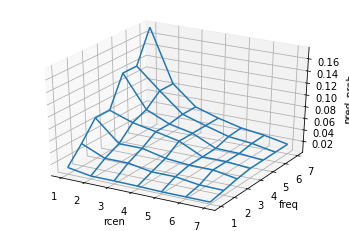

In [ ]:
# 最新度(rcen)と頻度(freq)に対して推定した再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df.freq.unique().tolist()
Rcen = rf_df.rcen.unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['pred_prob'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='pred_prob'
                    )
ax.plot_wireframe(X, Y, Z)

上記の平面をモデリングによって作成しているイメージ。

# モデルの適用

In [ ]:
# はじめに紹介したデータを作成
Rows4 = [('item1', 1, 6)
        , ('item2', 2, 2)
        , ('item3', 1, 2)
        , ('item4', 1, 1)
        ]
sample_df = pd.DataFrame(Rows4, columns=['item_name', 'rcen', 'freq'])
sample_df

,item_name,rcen,freq
0,item1,1,6
1,item2,2,2
2,item3,1,2
3,item4,1,1


In [ ]:
# 推定した再閲覧確率を結合
pd.merge(sample_df, rf_df, left_on=['rcen', 'freq'], right_on=['rcen', 'freq'])

,item_name,rcen,freq,N,pv,prob,pred_prob
0,item1,1,6,177,20,0.112994,0.121212
1,item2,2,2,3162,67,0.021189,0.022278
2,item3,1,2,3323,132,0.039723,0.039723
3,item4,1,1,19602,245,0.012499,0.012499


# モデルのブラッシュアップ

rcen
1         NaN
2   -0.011416
3    0.000150
4   -0.002528
5   -0.001805
6   -0.000856
7   -0.000793
Name: prob, dtype: float64

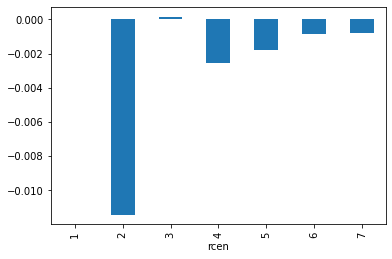

In [ ]:
# 最新度(rcen)に対して、再閲覧確率の下降幅が小さくなることを確認
rcen_df['prob'].diff().plot.bar()
rcen_df['prob'].diff()

freq
1         NaN
2    0.012805
3    0.013556
4    0.008247
5    0.005905
6    0.010783
7    0.003202
Name: prob, dtype: float64

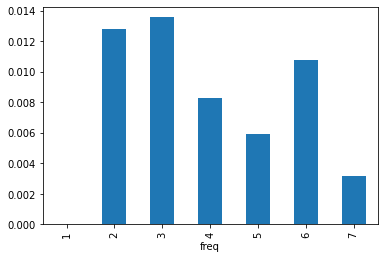

In [ ]:
# 頻度(freq)に対して、再閲覧確率の上昇幅が小さくなることを確認
freq_df['prob'].diff().plot.bar()
freq_df['prob'].diff()

## 上記より、以下の制約を追加して再モデリング
* Recencyに関する凸性（下に凸）：過去になればなるほど、再閲覧確率の下降幅が下がる。次第にゼロに収束
* Frequencyに関する凹性（上に凸）：閲覧数が増えればあ増えるほど、再閲覧率の上昇幅は減少する。次第に1に収束

In [ ]:
import cvxopt

R = sorted(tar_df['rcen'].unique().tolist())
F = sorted(tar_df['freq'].unique().tolist())

Idx = []
RF2Idx = {}
idx = 0
for r in R:
    for f in F:
        Idx.append(idx)
        RF2Idx[r, f] = idx 
        idx += 1

G_list = []
h_list = []
var_vec = [0.0] * len(Idx)

# - pred_prob[r,f] <= 0 のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = -1 # pred_prob[r,f]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0
        
# pred_prob[r,f] <= 1 のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        G_row = var_vec[:]
        G_row[idx] = 1
        G_list.append(G_row)
        h_list.append(1)        

# - pred_prob[r,f] + pred_prob[r+1,f] <= 0 のモデリング
for r in R[:-1]:
    for f in F:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r+1,f]
        G_row = var_vec[:]
        G_row[idx1] = -1 # pred_prob[r,f]の係数は-1
        G_row[idx2] = 1  # pred_prob[r+1,f]の係数は1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0        
        
# pred_prob[r,f] - pred_prob[r,f+1] <= 0 のモデリング
for r in R:
    for f in F[:-1]:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r,f+1]
        G_row = var_vec[:]
        G_row[idx1] = 1  # pred_prob[r,f]の係数は1
        G_row[idx2] = -1 # pred_prob[r,f+1]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0        
        
# - pred_prob[r,f] + 2 * pred_prob[r+1,f] - pred_prob[r+2,f] <= 0 のモデリング
for r in R[:-2]:
    for f in F:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r+1,f]
        idx3 = RF2Idx[r+2,f]
        G_row = var_vec[:]
        G_row[idx1] = -1 # pred_prob[r,f]の係数は-1
        G_row[idx2] = 2  # pred_prob[r+1,f]の係数は2
        G_row[idx3] = -1 # pred_prob[r+2,f]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0
        
# pred_prob[r,f] - 2 * pred_prob[r,f+1] + pred_prob[r,f+2] <= 0 のモデリング
for r in R:
    for f in F[:-2]:
        idx1 = RF2Idx[r,f]
        idx2 = RF2Idx[r,f+1]
        idx3 = RF2Idx[r,f+2]
        G_row = var_vec[:]
        G_row[idx1] = 1  # pred_prob[r,f]の係数は-1
        G_row[idx2] = -2 # pred_prob[r,f+1]の係数は2
        G_row[idx3] = 1  # pred_prob[r,f+2]の係数は-1
        G_list.append(G_row)
        h_list.append(0) # 右辺は定数項0
        
P_list = []
q_list = []

# N[r,f] * pred_prob[r,f]^2 - 2 * N[r,f] * prob[r,f] のモデリング
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        N = RF2N[r,f]
        prob = RF2Prob[r,f]
        P_row = var_vec[:]
        P_row[idx] = 2 * N # (1/2)を打ち消すために2を掛ける
        P_list.append(P_row)
        ｑ_list.append( - 2 * N * prob)

G = cvxopt.matrix(np.array(G_list), tc='d')
h = cvxopt.matrix(np.array(h_list), tc='d')
P = cvxopt.matrix(np.array(P_list), tc='d')
q = cvxopt.matrix(np.array(q_list), tc='d')

sol = cvxopt.solvers.qp(P, q, G, h)
status = sol['status']
print(status)

     pcost       dcost       gap    pres   dres
 0: -5.2387e+01 -1.0684e+02  5e+02  2e+00  2e-02
 1: -5.2162e+01 -7.3611e+01  5e+01  2e-01  1e-03
 2: -5.1452e+01 -6.2961e+01  2e+01  4e-02  4e-04
 3: -5.1298e+01 -5.5766e+01  6e+00  1e-02  8e-05
 4: -5.1190e+01 -5.2365e+01  1e+00  1e-03  1e-05
 5: -5.1182e+01 -5.1589e+01  4e-01  1e-04  1e-06
 6: -5.1206e+01 -5.1382e+01  2e-01  5e-05  4e-07
 7: -5.1216e+01 -5.1298e+01  8e-02  6e-06  5e-08
 8: -5.1223e+01 -5.1241e+01  2e-02  1e-06  1e-08
 9: -5.1225e+01 -5.1228e+01  2e-03  2e-16  2e-16
10: -5.1226e+01 -5.1226e+01  7e-05  1e-16  8e-16
11: -5.1226e+01 -5.1226e+01  1e-06  2e-16  2e-15
Optimal solution found.
optimal


In [ ]:
# 最新度(rcen)と頻度(freq)に対応する推定した再閲覧確率の辞書を作成
RF2PredProb2 = {}
X = sol['x']
for r in R:
    for f in F:
        idx = RF2Idx[r,f]
        pred_prob = X[idx]
        RF2PredProb2[r,f] = pred_prob
rf_df['pred_prob2'] = rf_df.apply(lambda x:RF2PredProb2[x['rcen'], x['freq']], axis=1)
rf_df.head()    

,rcen,freq,N,pv,prob,pred_prob,pred_prob2
0,1,1,19602,245,0.012499,0.012499,0.012499
1,1,2,3323,132,0.039723,0.039723,0.039723
2,1,3,1120,81,0.072321,0.070524,0.066240
3,1,4,539,36,0.066790,0.070524,0.087729
4,1,5,285,36,0.126316,0.121212,0.109218


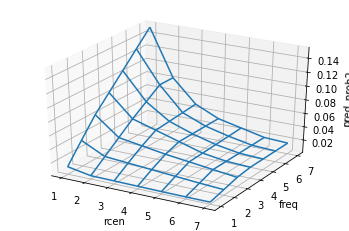

In [ ]:
# 最新度(rcen)と頻度(freq)に対して推定した再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df['freq'].unique().tolist()
Rcen = rf_df['rcen'].unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['pred_prob2'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='pred_prob2'
                    )
ax.plot_wireframe(X, Y, Z)

* グラフがなめらかになった

## 実務においては、制約の追加は十分に注意する。データが十分にある場合、過度な制約の追加は扱っている事象から離れていく可能性がある

#  凸二次計画問題の行列表現の補足

以下では freqに対応する変数 x1, x2, x3 だけの問題を考える。

それぞれの再閲覧確率を、p1=0.1, p2=0.15, p3=0.25 とし、

それぞれの総件数を、 N1=100, N2=50, N3=10 とすると、以下の2次計画問題が与えられる.



・確率の定義域
  * $\displaystyle  \begin{array}{{>{\displaystyle}l}}
0\leqq x_{1} \leqq 1\\
0\leqq x_{2} \leqq 1\\
0\leqq x_{3} \leqq 1
\end{array}$

・freqの単調性
  * 	$\displaystyle x_{1} \leqq x_{2}$

  * $\displaystyle x_{2} \leqq x_{3}$

・freqは上に凸
  * $\displaystyle x_{1} -x_{2} \geqq x_{3} -x_{2}$

・誤差の最小化

$\displaystyle 100( x_{1} -0.1)^{2} +50( x_{2} -0.15)^{2} +10( x_{3} -0.25)^{2}$　の最小化

* 2次計画問題の定式化の式
  * $\displaystyle minimize\ \frac{1}{2} x^{T} Px+q^{T} x$ 
$\displaystyle　 s.t　\ Gx\ \leqq \ h$

に対応する行列の形に書き換えると

・確率の定義域( Gx<=h の制約に対応)
  * 	$\displaystyle ( -1) x_{1} +0・x_{2} +0・x_{3} \leqq 0$

	$\displaystyle 1・x_{1} +0・x_{2} +0・x_{3} \leqq 1$

	$\displaystyle 0x_{1} +( -1) ・x_{2} +0・x_{3} \leqq 0$

	$\displaystyle 0・x_{1} +1・x_{2} +0・x_{3} \leqq 1$

	$\displaystyle 0x_{1} +0・x_{2} +( -1) ・x_{3} \leqq 0$

	$\displaystyle 0・x_{1} +0・x_{2} +1・x_{3} \leqq 1$



・freqの単調性

* $\displaystyle 1・x_{1} +( -1) ・x_{2} +0・x_{3} \leqq 0$

	$\displaystyle 0・x_{1} +1・x_{2} +( -1) ・x_{3} \leqq 0$



・freqは上に凸

* $\displaystyle 1・x_{1} +( -2) ・x_{2} +1・x_{3} \leqq 0$



・誤差の最小化(目的関数の定数項はx1,x2,x3に影響を与えないので削除）
* 	$\displaystyle \frac{1}{2}\left( 2・100x_{1}^{2} +2・50x_{2}^{2} +2・10x_{3}^{2}\right) +( -2・100・0.1x_{1} -2・50・0.15・x_{2} -2・10・0.25・x_{3})$

In [ ]:
import numpy as np
import cvxopt

G_list = [[-1, 0, 0]
         ,[ 1, 0, 0]
         ,[ 0,-1, 0]
         ,[ 0, 1, 0]
         ,[ 0, 0,-1]
         ,[ 0, 0, 1]
         ,[ 1,-1, 0]
         ,[ 0, 1,-1]
         ,[ 1,-2, 1]
]

h_list = [0
          ,1
          ,0
          ,1
          ,0
          ,1
          ,0
          ,0
          ,0]

P_list = [[2*100 ,0    ,0   ]
         ,[0     ,2*50 ,0   ]
         ,[0     ,0    ,2*10]
]

q_list = [-2 * 100 * 0.1
          ,-2 * 50 * 0.15
          ,-2 * 10 * 0.25
         ]

G = cvxopt.matrix(np.array(G_list), tc='d')
h = cvxopt.matrix(np.array(h_list), tc='d')
P = cvxopt.matrix(np.array(P_list), tc='d')
q = cvxopt.matrix(np.array(q_list), tc='d')

sol = cvxopt.solvers.qp(P, q, G, h)
status = sol['status']
print('status:',status)

X = sol['x']
for x in X:
    print('x:',x)

     pcost       dcost       gap    pres   dres
 0: -2.7425e+00 -6.4628e+00  2e+01  2e+00  2e-01
 1: -2.6356e+00 -4.4661e+00  2e+00  3e-16  1e-16
 2: -2.7282e+00 -2.8191e+00  9e-02  3e-16  3e-17
 3: -2.7361e+00 -2.7394e+00  3e-03  1e-16  7e-17
 4: -2.7368e+00 -2.7369e+00  3e-05  1e-16  7e-17
 5: -2.7368e+00 -2.7368e+00  3e-07  2e-16  9e-17
Optimal solution found.
status: optimal
x: 0.09736840835953961
x: 0.16052635585676464
x: 0.22368416017154524
